In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("cars.csv")

# Show first few rows
print(df.head())
print(df.info())


   Engine Size(L)  Cylinders  Fuel Consumption Comb (L/100 km)  \
0             2.0          4                               8.5   
1             2.4          4                               9.6   
2             1.5          4                               5.9   
3             3.5          6                              11.1   
4             3.5          6                              10.6   

   CO2 Emissions(g/km)  Unnamed: 4 Vehicle Class  
0                  196         NaN       COMPACT  
1                  221         NaN       COMPACT  
2                  136         NaN       COMPACT  
3                  255         NaN   SUV - SMALL  
4                  244         NaN   SUV - SMALL  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Engine Size(L)                    7385 non-null   float64
 1

In [28]:
df['km_per_litre'] = 100 / df['Fuel Consumption Comb (L/100 km)']


In [45]:
X = df[["Engine Size(L)", "Cylinders", "Fuel Consumption Comb (L/100 km)", "Vehicle Class"]]
y = df["CO2 Emissions(g/km)"]


In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Define transformer for categorical column
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["Vehicle Class"])
    ],
    remainder="passthrough"  # keep numeric columns as is
)

In [47]:
from sklearn.pipeline import Pipeline

rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),   # same OneHotEncoder for Vehicle Class
    ("regressor", RandomForestRegressor(
        n_estimators=200,     # number of trees
        random_state=42,
        max_depth=None,       # let it grow deep
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1             # use all CPU cores
    ))
])


In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [49]:
rf_model.fit(X_train, y_train)


c:\Users\Shreyas Kulkarni\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Vehicle Class'])])),
                ('regressor',
                 RandomForestRegressor(n_estimators=200, n_jobs=-1,
                                       random_state=42))])

In [50]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred_rf = rf_model.predict(X_test)

print("Random Forest MAE:", mean_absolute_error(y_test, y_pred_rf))
print("Random Forest R² Score:", r2_score(y_test, y_pred_rf))


Random Forest MAE: 2.979410520597808
Random Forest R² Score: 0.9863742923322388


In [55]:
sample = pd.DataFrame([{
    "Engine Size(L)": 1.4,
    "Cylinders": 4,
    "Fuel Consumption Comb (L/100 km)": 5.2,
    "Vehicle Class": "compact"
}])

predicted_co2_rf = rf_model.predict(sample)
print("Predicted CO2 Emissions (Random Forest):", predicted_co2_rf[0], "g/km")


Predicted CO2 Emissions (Random Forest): 120.2903095238095 g/km


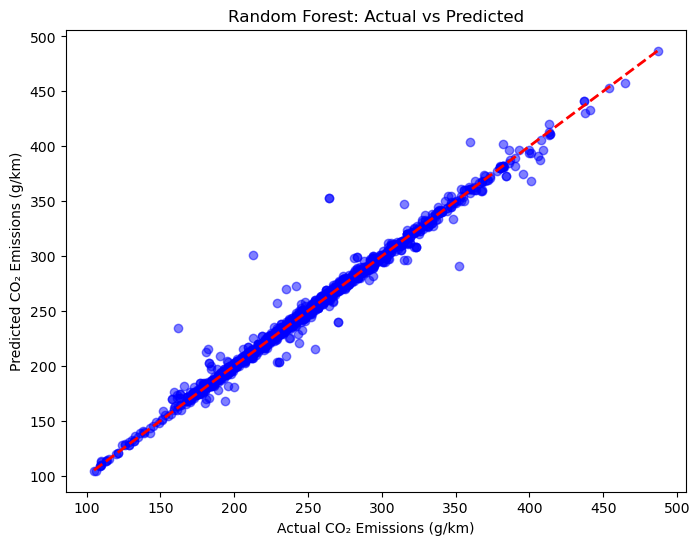

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # ideal line
plt.xlabel("Actual CO₂ Emissions (g/km)")
plt.ylabel("Predicted CO₂ Emissions (g/km)")
plt.title("Random Forest: Actual vs Predicted")
plt.show()


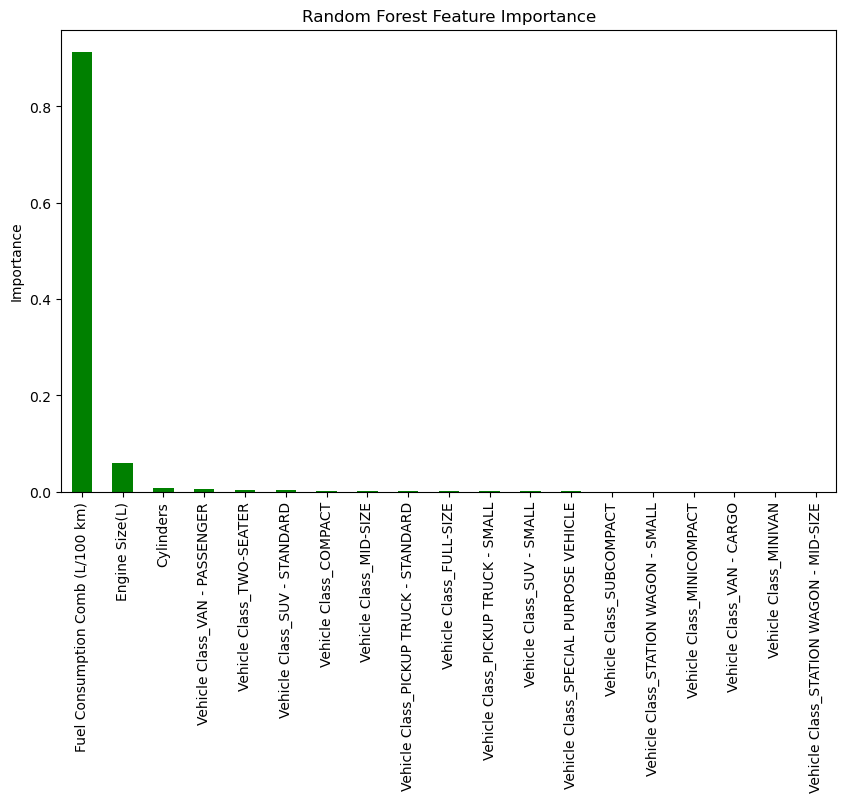

In [56]:
# Get feature names from encoder
ohe = rf_model.named_steps["preprocessor"].named_transformers_["cat"]
ohe_features = list(ohe.get_feature_names_out(["Vehicle Class"]))
all_features = ohe_features + ["Engine Size(L)", "Cylinders", "Fuel Consumption Comb (L/100 km)"]

# Get importance
importances = rf_model.named_steps["regressor"].feature_importances_
feature_importance = pd.Series(importances, index=all_features).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,6))
feature_importance.plot(kind="bar", color="green")
plt.title("Random Forest Feature Importance")
plt.ylabel("Importance")
plt.show()
